# Training and deploying a tabular model using Vertex AutoML.

![Training pipeline]()

## Import the required packages

In [1]:
import os
import pprint
import pandas as pd
import tensorflow as tf
import time

import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform_v1beta1 import types
from google.cloud import bigquery
from google.cloud import exceptions

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow_io import bigquery as tfio_bq


## Configure GCP settings

*Before running the notebook make sure to follow the repo's README file to install the pre-requisites and configure GCP authentication.*

In [2]:
PROJECT = 'jk-test-1002'
REGION = 'us-central1'
PREFIX = 'jtest2'

STAGING_BUCKET = f'gs://{PREFIX}-bucket'
VERTEX_SA = f'training-sa@{PROJECT}.iam.gserviceaccount.com'

## Preparing training data in BigQuery

### Explore Chicago Taxi dataset

In [3]:
%%bigquery data

SELECT 
    *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.60rows/s]


In [4]:
data.head().T

,0,1,2
unique_key,c94389b623bc4cf71a8e5c3c5cbb2e869a36c27c,79413052408658d75f4cdae8c92c1a4a3bd9106c,02e3e939ba3f3eb2911bf9ef5de7c52f886b6f51
taxi_id,829068cca943239510ecaf4b37471e8d7816c49b70f7c6...,829068cca943239510ecaf4b37471e8d7816c49b70f7c6...,829068cca943239510ecaf4b37471e8d7816c49b70f7c6...
trip_start_timestamp,2015-10-03 17:00:00+00:00,2015-10-03 17:30:00+00:00,2015-10-02 10:45:00+00:00
trip_end_timestamp,2015-10-03 17:15:00+00:00,2015-10-03 17:45:00+00:00,2015-10-02 10:45:00+00:00
trip_seconds,840,900,180
trip_miles,4.4,5.7,0.8
pickup_census_tract,NaN,NaN,NaN
dropoff_census_tract,NaN,NaN,NaN
pickup_community_area,NaN,NaN,NaN
dropoff_community_area,NaN,NaN,NaN


In [5]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.44rows/s]


In [6]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,4141154
1,2,Monday,4105900
2,3,Tuesday,4378805
3,4,Wednesday,4542810
4,5,Thursday,4918190
5,6,Friday,5289830
6,7,Saturday,5009186


<AxesSubplot:xlabel='trip_dayname'>

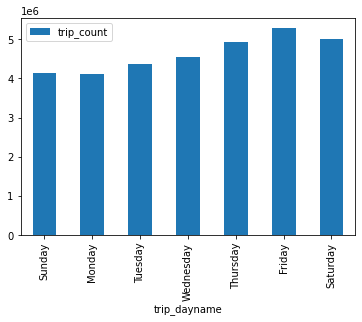

In [7]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create data splits

In [8]:
BQ_DATASET_NAME = f'{PREFIX}_dataset' 
BQ_TABLE_NAME = 'features'
BQ_LOCATION = 'US'
SAMPLE_SIZE = 500000
YEAR = 2020

#### Create a BQ dataset to host the splits

In [9]:
client = bigquery.Client()

dataset_id = f'{PROJECT}.{BQ_DATASET_NAME}'
dataset = bigquery.Dataset(dataset_id)
dataset.location = BQ_LOCATION

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print('Created dataset: ', dataset_id)
except exceptions.Conflict:
    print('Dataset {} already exists'.format(dataset_id))

Created dataset:  jk-test-1001.jtest1_dataset


#### Create a table with training features

In [10]:
sample_size = 1000000
year = 2020

sql_script_template = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        FORMAT_DATETIME('%Y-%d-%m', trip_start_timestamp) AS date,
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      CASE (ABS(MOD(FARM_FINGERPRINT(date),10))) 
          WHEN 9 THEN 'TEST'
          WHEN 8 THEN 'VALIDATE'
          ELSE 'TRAIN' END AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

sql_script = sql_script_template.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

job = client.query(sql_script)
job.result()

#### Review the created features

In [11]:
sql_script = f'''
SELECT * EXCEPT (trip_start_timestamp)
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
'''
df = client.query(sql_script).result().to_dataframe()

In [12]:
df.head().T

,0,1,2,3,4
trip_month,6,6,6,6,6
trip_day,19,19,19,19,19
trip_day_of_week,6,6,6,6,6
trip_hour,0,0,0,0,0
trip_seconds,619,241,383,660,480
trip_miles,0.78,0.77,0.8,1.1,1.5
payment_type,Cash,Cash,Credit Card,Cash,Cash
pickup_grid,POINT(-87.7 42),POINT(-87.7 41.9),POINT(-87.6 41.9),POINT(-87.7 41.9),POINT(-87.6 41.9)
dropoff_grid,POINT(-87.7 42),POINT(-87.7 41.9),POINT(-87.6 41.9),POINT(-87.6 41.9),POINT(-87.6 41.9)
euclidean,3000.241665,0.0,0.0,3788.78383,0.0


## Creating a tabular dataset in Vertex

### Initialize Vertex AI SDK

In [13]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET
)

### Create a dataset and import data

In [14]:
display_name = 'Chicago taxi trips'
bq_source_uri = f'bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}'

filter = f'display_name="{display_name}"'

dataset = vertex_ai.TabularDataset.list(filter=filter)
if not dataset:
    print("Creating a new dataset.")
    dataset = vertex_ai.TabularDataset.create(
        display_name=display_name, bq_source=bq_source_uri,
    )

    dataset.wait()
else:
    print("Using existing dataset: ", dataset[0].resource_name)
    dataset = vertex_ai.TabularDataset(dataset_name=dataset[0].resource_name)

Creating a new dataset.
INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/65941581161/locations/us-central1/datasets/9073847251570262016/operations/9138780285138108416
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/65941581161/locations/us-central1/datasets/9073847251570262016
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/65941581161/locations/us-central1/datasets/9073847251570262016')


## Launching an AutoML training job

In [15]:
display_name = 'Chicago Taxi classifier training'
model_display_name = 'Chicago Taxi classifier'
target_column = 'tip_bin'
optimization_prediction_type = 'classification'
optimization_objective = 'maximize-recall-at-precision'
optimization_objective_precision_value = 0.7
split_column = 'data_split'
budget_milli_node_hours = 1000

column_transformations = [
    {'categorical': {'column_name': 'trip_month'}},
    {'categorical': {'column_name': 'trip_day'}},
    {'categorical': {'column_name': 'trip_day_of_week'}},
    {'categorical': {'column_name': 'trip_hour'}},
    {'categorical': {'column_name': 'payment_type'}},
    {'categorical': {'column_name': 'pickup_grid'}},
    {'categorical': {'column_name': 'dropoff_grid'}},
    {'numeric': {'column_name': 'trip_seconds'}},
    {'numeric': {'column_name': 'euclidean'}},
    {'numeric': {'column_name': 'trip_miles'}},
]

job = vertex_ai.AutoMLTabularTrainingJob(
    display_name=display_name,
    optimization_prediction_type=optimization_prediction_type,
    optimization_objective=optimization_objective,
    optimization_objective_precision_value=optimization_objective_precision_value,
    column_transformations=column_transformations,
)

model = job.run(
    dataset=dataset,
    target_column=target_column,
    budget_milli_node_hours=budget_milli_node_hours,
    model_display_name=model_display_name,
    predefined_split_column_name=split_column,
    sync=False
)

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8491189651732692992?project=65941581161
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/65941581161/locations/us-central1/trainingPipelines/8491189651732692992 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/65941581161/locations/us-central1/trainingPipelines/8491189651732692992 current state:
PipelineState.PIPELINE_STATE_PENDING
